In [3]:
import pickle
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner
from sklearn import metrics
from scipy.stats import boxcox

In [2]:
with open("tokenizeddata_updated.pkl", "rb") as f:
    df = pickle.load(f)
VOCAB_SIZE = 65094

NameError: name 'pickle' is not defined

In [307]:
a = df.drop(columns=["synopsis sequences", "Unnamed: 0"])
a = (a-a.min())/(a.max()-a.min())
a.skew().sort_values(ascending=False)

Biography           2.929097
imdbid              2.399577
Fantasy             2.277365
characters          2.171437
Horror              2.073114
Mystery             2.008407
Sci-Fi              1.769429
Adventure           1.619560
Romance             1.560062
Surprise            1.512680
Crime               1.442285
Positive            1.436885
Sadness             1.420082
Negative            1.412095
Anger               1.396228
Trust               1.380346
Joy                 1.318338
Fear                1.284241
scenes              1.206921
Disgust             1.170371
Anticipation        1.159067
Action              0.946741
locations           0.922959
Comedy              0.854625
Thriller            0.506101
percent dialogue    0.299158
Top 3               0.057308
Drama              -0.283874
metascore          -0.293499
dtype: float64

In [308]:
torch.set_float32_matmul_precision('high')

In [309]:
class CombinedDataset(Dataset):
    def __init__(self, data):
        self.sequences = data["synopsis sequences"]
        self.metascores = data["metascore"]
        self.tabular = data.drop(columns=["imdbid", "metascore", "synopsis sequences", "Unnamed: 0"])
        self.tabular = self.tabular.apply(lambda x: x + 1)
        for column in self.tabular.columns:
            self.tabular[column] = boxcox(self.tabular[column])[0]
        self.tabular = (self.tabular-self.tabular.min())/(self.tabular.max()-self.tabular.min())

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.tabular.iloc[idx, 0:]

        y = self.metascores.iloc[idx]

        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)

        sequence = self.sequences.iloc[idx]

        return sequence, tabular, y

In [310]:
def convblock(input_size, output_size, filter_size, stride = 1, maxpool_size = 2):
    return nn.Sequential(nn.Conv1d(input_size, output_size, filter_size, stride), nn.ReLU(), nn.MaxPool1d(maxpool_size))

In [440]:
class CombinedModel(pl.LightningModule):
    def __init__(self, num_workers: int = 4, batch_size: int = 32, lr: float = 0.001365158322401656, embedsize: int = 300):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.criterion = nn.MSELoss

        self.embeddings = nn.Embedding(VOCAB_SIZE, embedsize)

        self.convos = nn.Sequential(convblock(embedsize, 512, 2),
                                    convblock(512, 256, 3),
                                    convblock(256, 128, 4),
                                    convblock(128, 32, 5),
                                    )

        self.convnet = nn.Sequential(nn.Linear(13888, 200),
                                    #  nn.Dropout(p=0.5),
                                     nn.ReLU(),
                                     nn.Linear(200, 32),
                                     nn.ReLU(),
                                     )

        self.tabnet = nn.Sequential(nn.Linear(27, 800),
                                    nn.LeakyReLU(),
                                    nn.Linear(800, 600),
                                    nn.LeakyReLU(),
                                    nn.Linear(600, 64),
                                    nn.LeakyReLU(),
                                    # nn.Dropout(p=0.5),
                                    nn.Linear(64, 600),
                                    nn.LeakyReLU(),
                                    nn.Linear(600, 20),
                                    nn.LeakyReLU(),
                                    )
        
        self.combonet = nn.Sequential(nn.Linear(20 + 32, 32),
                                      nn.Dropout(p=0.5),
                                      nn.LeakyReLU(),
                                      nn.Linear(32, 1),
                                      )

    def forward(self, seq, tab):
        seq = self.embeddings(seq)
        seq = torch.transpose(seq, 1, 2)
        seq = self.convos(seq)
        seq = seq.reshape(seq.shape[0], -1)
        seq = self.convnet(seq)

        tab = self.tabnet(tab)

        x = torch.cat((seq, tab), dim=1)
        return self.combonet(x)
    
    def training_step(self, batch, batch_idx):
        seq, tabular, y = batch

        criterion = self.criterion()
        y_pred = torch.flatten(self(seq, tabular))
        y_pred = y_pred.double()

        loss = criterion(y_pred, y)

        self.log("train_loss_L1", torch.nn.L1Loss()(y_pred, y))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        seq, tabular, y = batch

        criterion = self.criterion()
        y_pred = torch.flatten(self(seq, tabular))
        y_pred = y_pred.double()

        val_loss = criterion(y_pred, y)

        self.log("validation_loss_L1", torch.nn.L1Loss()(y_pred, y))
        self.log("validation_loss", val_loss)
        return val_loss

    def test_step(self, batch, batch_idx):
        seq, tabular, y = batch

        criterion = self.criterion()
        y_pred = torch.flatten(self(seq, tabular))
        y_pred = y_pred.double()

        test_loss = criterion(y_pred, y)
        self.log("test_loss_L1", torch.nn.L1Loss()(y_pred, y))
        self.log("test_loss", test_loss)
        return test_loss
    
    def setup(self, stage):

        data = CombinedDataset(df)

        self.train_set, self.val_set, self.test_set = random_split(data, (0.7, 0.2, 0.1))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr), weight_decay=0.0)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, pin_memory=True)
    
    def predict_dataloader(self):
        return DataLoader(CombinedDataset(df), batch_size=self.batch_size, pin_memory=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        seq, tabular, _ = batch
        return torch.flatten(self(seq, tabular))

In [441]:
model = CombinedModel()
trainer = pl.Trainer(accelerator="gpu", max_epochs=100, log_every_n_steps=5, callbacks=[EarlyStopping(monitor="validation_loss_L1", mode="min", patience=12, min_delta=2)])
tuner = Tuner(trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [442]:
# tuner.lr_find(model)
trainer.fit(model)
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | embeddings | Embedding  | 19.5 M
1 | convos     | Sequential | 852 K 
2 | convnet    | Sequential | 2.8 M 
3 | tabnet     | Sequential | 592 K 
4 | combonet   | Sequential | 1.7 K 
------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.038    Total estimated model params size (MB)


C:\Users\Edan\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Edan\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 13: 100%|██████████| 28/28 [00:03<00:00,  8.88it/s, v_num=271]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Edan\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 27.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     144.670531695612      │
│       test_loss_L1        │     9.141606361146957     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_L1': 9.141606361146957, 'test_loss': 144.670531695612}]

In [443]:
out = trainer.predict(model, ckpt_path="best")
preds = []
for ten in out:
    preds.extend(ten.tolist())

df2 = df.copy()
df2["predicted"] = df2.apply(lambda x: preds[x.name],axis=1)

Restoring states from the checkpoint path at c:\Users\Edan\Desktop\Code\148\project\lightning_logs\version_271\checkpoints\epoch=13-step=392.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\Edan\Desktop\Code\148\project\lightning_logs\version_271\checkpoints\epoch=13-step=392.ckpt
C:\Users\Edan\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 26.56it/s]


In [1]:
r2 = metrics.r2_score(df2["metascore"].values, df2["predicted"].values)
mae = metrics.mean_absolute_error(df2["metascore"].values, df2["predicted"].values)
print("r2: ",r2, "\nmae: ", mae)

NameError: name 'metrics' is not defined

<Axes: >

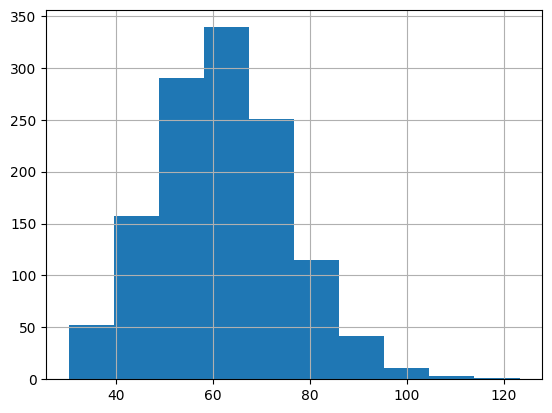

In [450]:
df2["predicted"].hist(bins=10)

<Axes: >

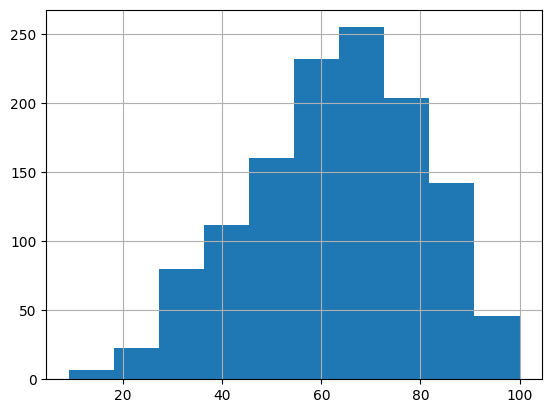

In [448]:
df2["metascore"].hist(bins=10)